In [1]:
import pandas as pd
import geopandas as gpd
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import mapclassify
from pysal.viz import splot
from splot.esda import plot_moran
from pysal.explore import esda
from pysal.lib import weights

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/homebrew/anaconda3/envs/dengue-data-exploration/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/opt/homebrew/anaconda3/envs/dengue-data-exploration/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create a SQLAlchemy engine
conn_string = "postgresql://lizavabistsevits:@localhost:5432/taiwan" # database connection string
engine = create_engine(conn_string)

# Insert dengue cases into geodataframe
tw = gpd.read_postgis(
    "SELECT * FROM dengue_total_2012_2024_all_geom",
    engine,
    geom_col="geom"
)

tw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   code            349 non-null    int64   
 1   name            349 non-null    object  
 2   county          349 non-null    int64   
 3   total_pop       349 non-null    int64   
 4   case_count      349 non-null    int64   
 5   dengue_per_10k  349 non-null    float64 
 6   geom            349 non-null    geometry
dtypes: float64(1), geometry(1), int64(4), object(1)
memory usage: 19.2+ KB


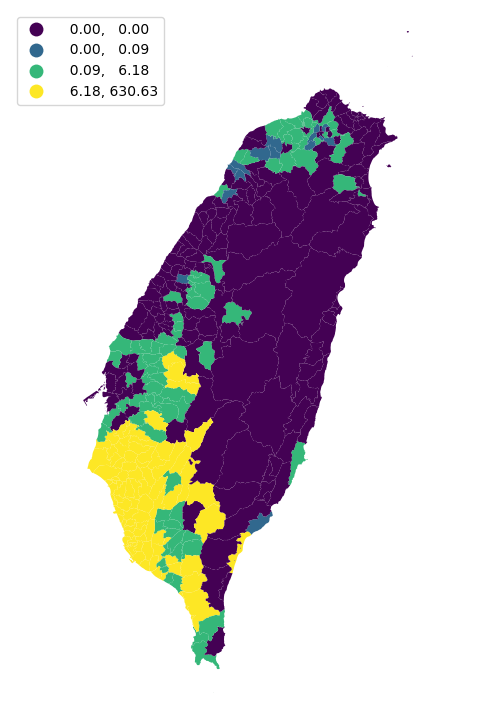

In [56]:
f, ax = plt.subplots(1, figsize=(9, 9))
tw.plot(
    column="dengue_per_10k",
    cmap="viridis",
    scheme="quantiles",
    k=4,
    legend=True,
    legend_kwds={"loc": "upper left"},
    ax=ax,
)

# Specify coordinates for the plot
ax.set_xlim(100000, 400000)
ax.set_ylim(2400000, 2850000)

ax.set_axis_off()

In [25]:
# Custom classification scheme
cutsom_scheme = mapclassify.UserDefined(
    tw['dengue_per_10k'], [0, 1, 10, 50, 631]
)
cutsom_scheme

UserDefined

    Interval       Count
------------------------
[  0.00,   0.00] |   160
(  0.00,   1.00] |    63
(  1.00,  10.00] |    53
( 10.00,  50.00] |    39
( 50.00, 631.00] |    34

(2400000.0, 2850000.0)

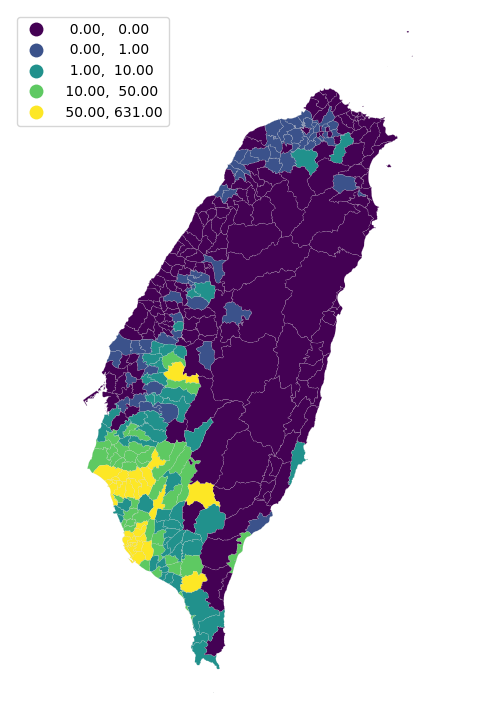

In [54]:
f, ax = plt.subplots(1, figsize=(9, 9))
cutsom_scheme.plot(
    tw, 
    legend=True,
    legend_kwds={"loc": "upper left"},
    axis_on=False,  
    cmap="viridis",
    ax=ax,
)

# Specify coordinates for the plot
ax.set_xlim(100000, 400000)
ax.set_ylim(2400000, 2850000)

In [4]:
# Generate spatial weights (k-nearest neigbor)
w = weights.KNN.from_dataframe(tw, k=8)

# Row-standardization
w.transform = 'R'

### Moran's I

In [5]:
# Strandardise by subtracting mean
tw['dengue_per_10k_std'] = tw['dengue_per_10k'] - tw['dengue_per_10k'].mean()

# Calculate spatial lag
tw['dengue_per_10k_lag_std'] = weights.lag_spatial(w, tw['dengue_per_10k_std'])

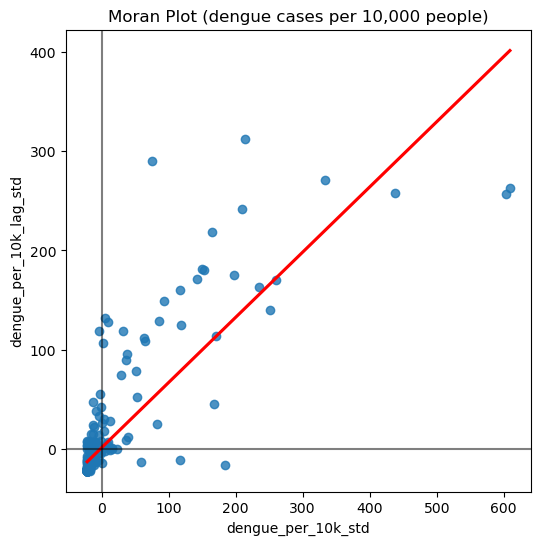

In [50]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x='dengue_per_10k_std',
    y='dengue_per_10k_lag_std',
    ci=None,
    data=tw,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot (dengue cases per 10,000 people)")
plt.show()


In [7]:
# Calculate Moran's I
moran = esda.moran.Moran(tw['dengue_per_10k'], w)

print(f"Moran's I: {moran.I}")
print(f"Pseudo p-value: {moran.p_sim}")

Moran's I: 0.6557544180027932
Pseudo p-value: 0.001


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.66', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.66)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

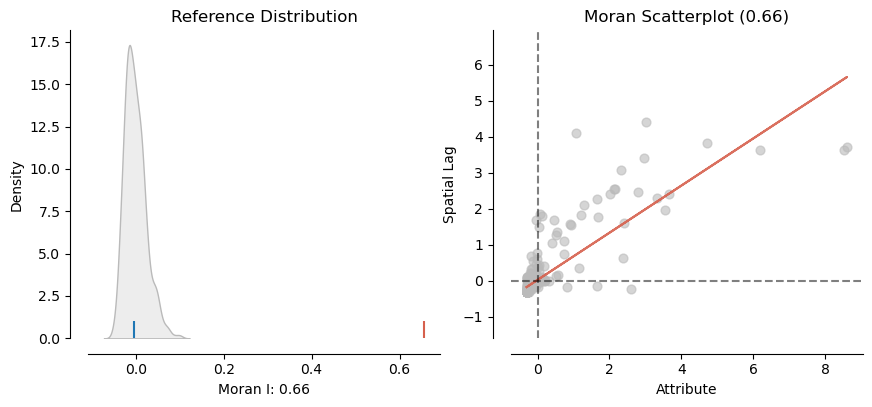

In [8]:
plot_moran(moran)

### Geary's C

In [9]:
# Calculate Geary's C
geary = esda.geary.Geary(tw['dengue_per_10k'], w)

print(f"Geary's C: {geary.C}")
print(f"Pseudo p-value: {geary.p_sim}")

Geary's C: 0.38116027551197246
Pseudo p-value: 0.001


### Getis and Ord's G

In [10]:
# Calculate minimum threshold distance to ensure every observation has at least one neighbour
pts = tw.centroid
xys = pd.DataFrame({"X": pts.x, "Y": pts.y})
min_thr = weights.util.min_threshold_distance(xys)

print(f"Minimum threshold distance: {min_thr} meters")

Minimum threshold distance: 81235.69428160728 meters


In [11]:
# Calculate Getis and Ord's G using minimum threshold distance
w_tw = weights.DistanceBand.from_dataframe(tw, min_thr)
gao = esda.getisord.G(tw['dengue_per_10k'], w_tw)

print(f"Getis and Ord's G: {gao.G}")
print(f"Pseudo p-value: {gao.p_sim}")

Getis and Ord's G: 0.895445736095029
Pseudo p-value: 0.001
